In [76]:
# Step 1: Install and import dependencies
import sys, subprocess

def install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

try:
    import requests
except ImportError:
    install("requests")
    import requests

try:
    import nltk
except ImportError:
    install("nltk")
    import nltk

# Download essential NLTK resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("maxent_ne_chunker")
nltk.download("words")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("maxent_ne_chunker_tab")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk

True

In [77]:
# Step 2: Download the novel (plain text file)
gutenberg_url = "https://www.gutenberg.org/cache/epub/77439/pg77439.txt"
response = requests.get(gutenberg_url, timeout=30)

if response.status_code != 200:
    raise RuntimeError(f"Failed to download: {response.status_code}")

raw_text = response.text

In [78]:
# Step 3: Trim Gutenberg header/footer
start_marker = "*** START OF"
end_marker = "*** END OF"
start_idx = raw_text.find(start_marker)
end_idx = raw_text.find(end_marker)
if start_idx != -1 and end_idx != -1:
    clean_text = raw_text[start_idx:end_idx]
else:
    clean_text = raw_text

# Save locally
with open("novel_raw.txt", "w", encoding="utf-8") as f:
    f.write(clean_text)

In [79]:
# Step 4: Preprocess text
import re
text_lower = clean_text.lower()
text_no_punct = re.sub(r"[^a-z0-9\s]", " ", text_lower)
text_clean = re.sub(r"\s+", " ", text_no_punct).strip()

In [80]:
# Tokenization
from nltk.tokenize import sent_tokenize, word_tokenize
sentences = sent_tokenize(clean_text)   # sentence-level
words = word_tokenize(text_clean)       # word-level

print(f"Sentences: {len(sentences)}")
print(f"Words: {len(words)}")

Sentences: 1260
Words: 13511


In [81]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
words_no_sw = [w for w in words if w not in stop_words and w.isalpha()]

In [82]:
# Step 6: Frequency distribution
from nltk.probability import FreqDist
fdist = FreqDist(words_no_sw)
print("\nTop 20 words (no stopwords):")
for word, freq in fdist.most_common(20):
    print(f"{word}: {freq}")


Top 20 words (no stopwords):
que: 553
de: 388
la: 315
joseph: 264
es: 196
ignasi: 183
mercedes: 170
per: 164
rimbau: 156
el: 145
en: 134
l: 130
si: 126
un: 124
rosa: 123
joanet: 122
ja: 117
n: 99
ho: 93
jo: 92


In [83]:
# Step 7: Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
stems = [stemmer.stem(w) for w in words_no_sw]
fdist_stems = FreqDist(stems)
print("\nTop 20 stems:")
for stem, freq in fdist_stems.most_common(20):
    print(f"{stem}: {freq}")


Top 20 stems:
que: 554
de: 388
la: 320
joseph: 264
es: 196
el: 190
ignasi: 183
merced: 170
per: 164
rimbau: 156
en: 139
l: 130
un: 129
si: 126
rosa: 123
joanet: 122
ja: 117
n: 99
ho: 93
jo: 92


In [84]:
# Step 8: POS tagging
sample_tokens = words_no_sw[:500]
pos_tags = nltk.pos_tag(sample_tokens)
print("\nSample POS tags (first 25):")
for token, tag in pos_tags[:25]:
    print(f"{token}: {tag}")


Sample POS tags (first 25):
start: NN
project: NN
gutenberg: NN
ebook: VB
gent: NN
ara: NN
gent: NN
ara: IN
comedia: NN
en: FW
dos: NN
actes: VBZ
eduard: RB
coca: JJ
vallmajor: JJ
la: NN
mem: FW
ria: NN
del: NN
meu: JJ
germ: JJ
joan: NN
de: IN
la: FW
creu: FW


In [85]:
# Step 9: Named Entity Recognition
sample_sents = sentences[:10]
tokenized_sents = [word_tokenize(s) for s in sample_sents]
pos_tagged_sents = [nltk.pos_tag(ts) for ts in tokenized_sents]
ner_chunks = [nltk.ne_chunk(tags) for tags in pos_tagged_sents]

print("\nNamed entities (sample):")
for tree in ner_chunks:
    for subtree in tree:
        if hasattr(subtree, "label") and subtree.label() in ("PERSON", "ORGANIZATION", "GPE"):
            entity = " ".join(token for token, _ in subtree.leaves())
            print(f"{subtree.label()}: {entity}")


Named entities (sample):
ORGANIZATION: THE
ORGANIZATION: PROJECT
ORGANIZATION: Comedia
PERSON: Eduard Coca
PERSON: Joan de
PERSON: Creu
GPE: Serio
PERSON: Rimbau
GPE: Dòna
GPE: Vesteix
ORGANIZATION: DONYA
PERSON: Senyora
GPE: Té
GPE: Porta
ORGANIZATION: SENYOR
PERSON: Marit


In [86]:
from nltk.util import ngrams
from nltk import FreqDist

# Generate all bigrams (pairs of consecutive words) from words_no_sw and store them as a list of tuples.
bigrams = list(ngrams(words_no_sw, 2))

# Generate all trigrams (triplets of consecutive words) from words_no_sw and store them as a list of tuples.
trigrams = list(ngrams(words_no_sw, 3))

fdist_bi = FreqDist(bigrams)
fdist_tri = FreqDist(trigrams)

#printing the most common bigram and trigram along with its frequency count
for bg, freq in fdist_bi.most_common(10):
    print(f"{' '.join(bg)}: {freq}")
for bg, freq in fdist_tri.most_common(10):
    print(f"{' '.join(bg)}: {freq}")

de la: 50
lo que: 46
senyor joseph: 34
que es: 34
que l: 26
hi ha: 24
ja ho: 23
es que: 23
en joanet: 21
la meva: 21
la meva na: 8
que en joanet: 6
senyor joseph joseph: 6
qu vol dir: 6
lo que es: 6
se n va: 5
donya mercedes mercedes: 5
llegir el diari: 5
que es el: 5
la senyora rosa: 4


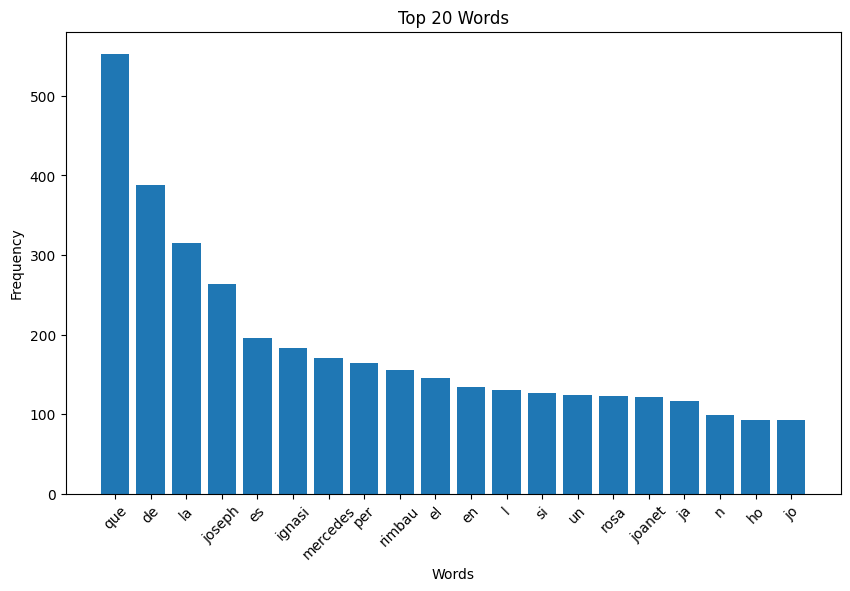

In [88]:
import matplotlib.pyplot as plt
from nltk import FreqDist

fdist = FreqDist(words_no_sw)
top_words = fdist.most_common(20)

words, freqs = zip(*top_words)

plt.figure(figsize=(10,6))
plt.bar(words, freqs)
plt.xticks(rotation=45)
plt.title("Top 20 Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()


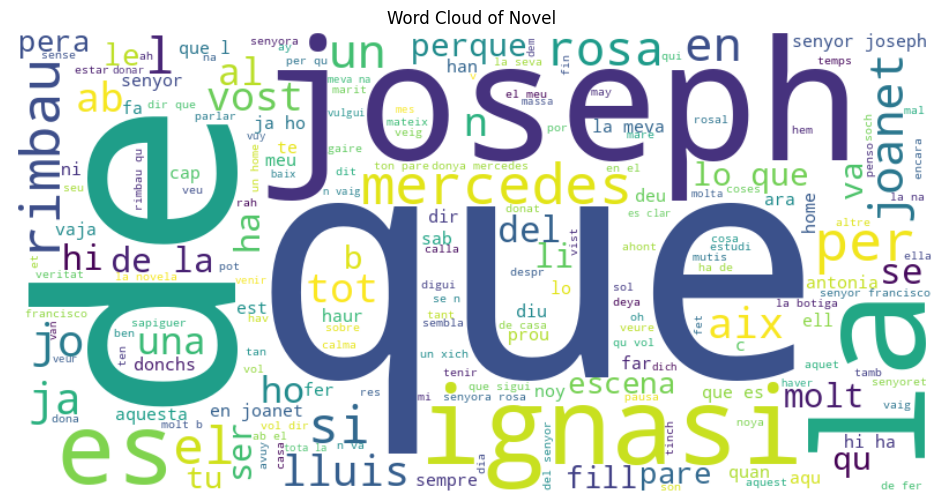

In [89]:
from wordcloud import WordCloud

text_for_wc = " ".join(words_no_sw)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_for_wc)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Novel")
plt.show()

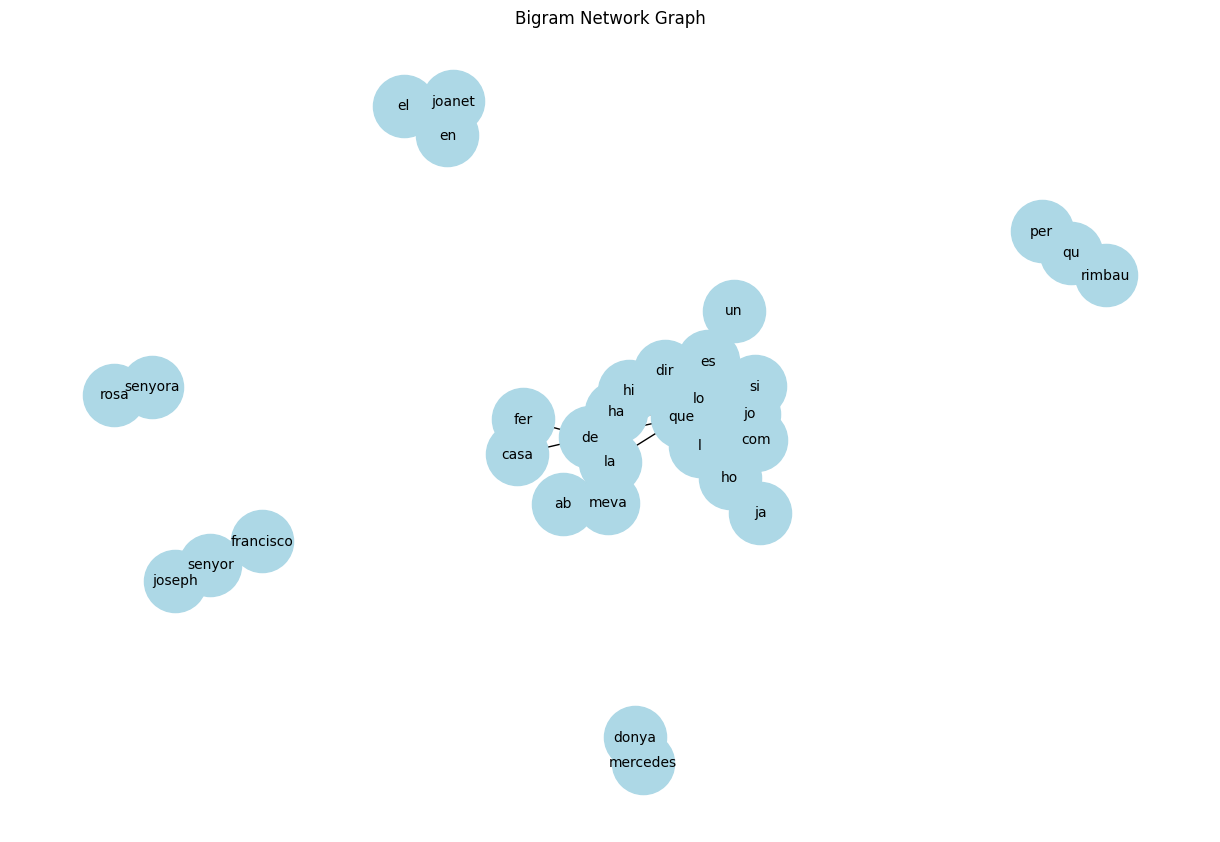

In [90]:
import networkx as nx

# Take top 30 bigrams
top_bigrams = fdist_bi.most_common(30)

G = nx.Graph()
for (w1, w2), freq in top_bigrams:
    G.add_edge(w1, w2, weight=freq)

plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10)
plt.title("Bigram Network Graph")
plt.show()